In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import string

from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhilsakhamuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data Preprocessing

We will read in the data and preprocess same as before.

In [16]:
#read in the data and add class labels
real = pd.read_csv('./data/True.csv')
fake = pd.read_csv('./data/Fake.csv')

real['fake'] = 0
fake['fake'] = 1

In [17]:
articles = pd.concat([real, fake])

In [18]:
#the same preprocess stemmer used in the prior notebook
def preprocess_stem(text):
    #Tokenize text
    tokens = word_tokenize(text.lower())
    
    #define stop words and punctuation
    stop_words = stopwords.words('english')
    punc = list(string.punctuation)
    
    #Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and token not in punc]
    
    return ' '.join(stemmed_tokens)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(articles['title'].apply(preprocess_stem), articles['fake'],
                                                   test_size=0.25, random_state=42)

### Model Evaluation

We will begin by fitting our optimal Random Forest model as found in the prior notebook. 

In [8]:
#create the pipeline object with the appropriate vectorizer and fit it on the training data
rf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', RandomForestClassifier(max_depth=None,
                                    max_features=5,
                                    n_estimators=1000))
])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 RandomForestClassifier(max_features=5, n_estimators=1000))])

#### Model Metrics

Below we will create a list of our model's predictions and use them to calculate the accuracy score, precision score, and recall score. Recall that in our data, a 1 stands for a 'fake' article and a 0 stands for a real article.

In [9]:
y_pred = rf_pipe.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print('Metrics of Random Forest model:')
print(f'Accuracy: {rf_accuracy}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')

Metrics of Random Forest model:
Accuracy: 0.9575055679287305
Precision: 0.972457627118644
Recall: 0.9449305198147195


Lets break down what each of these 3 metrics mean. Accuracy simply stands for the total rate at which our model correctly predicted class label, for both fake and real articles. 

In this setting, a precision score of 97.2% means that out of all the articles that our model predicted to be fake, 97.2% were indeed fake. 2.8% of the articles that our model predicted to be fake were actually real. 

A recall score of 94.5% means that out of all the total fake articles in the test data set, our model correctly predicted 94.5% of them to be fake. 5.5% of the fake articles were incorrectly predicted to be real. 

### Model Interpretation 

Now lets move on to understanding how our model reaches a decision on whether or not an article is fake. Using the feature_importances_ method of the RandomForestClassifier we can get a breakdown of which tokens were most important in determining whether an article was fake or not. Below is a plot of the 25 most important features to the Random Forest-

In [19]:
#get the indices of the top 25 most important features
feature_importances = rf_pipe['model'].feature_importances_

top_ind = np.argpartition(feature_importances, -25)[-25:]

top_tokens = rf_pipe['vectorizer'].get_feature_names_out()[top_ind]
top_tokens_importances = feature_importances[top_ind]

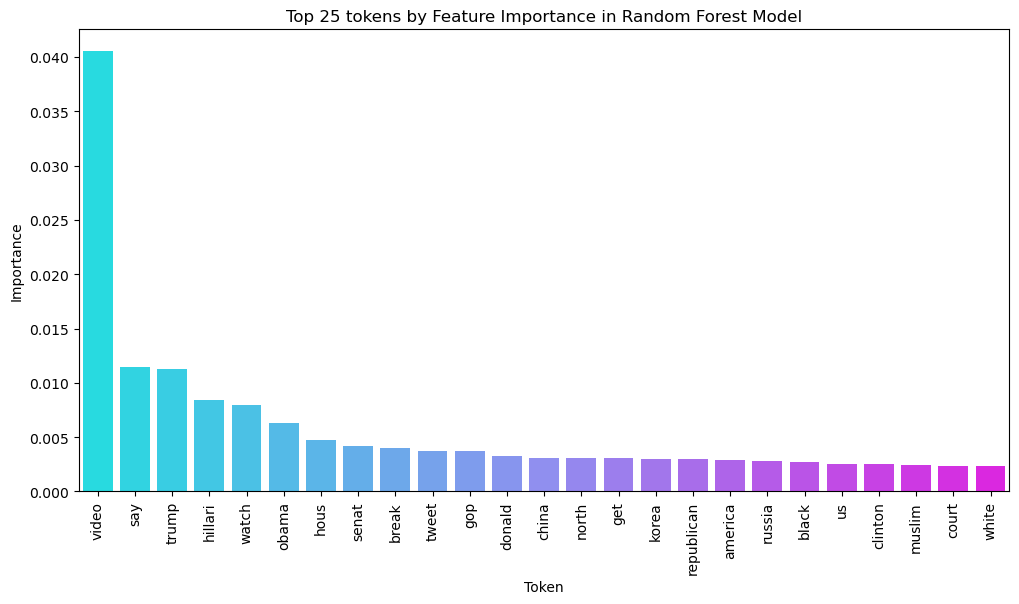

In [20]:
#plot the data
fig, ax = plt.subplots(figsize=(12,6))

_ = sns.barplot(x = top_tokens, y = top_tokens_importances, palette = 'cool',
               order = [token for _, token in sorted(zip(top_tokens_importances, top_tokens), reverse=True)])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel='Token', ylabel='Importance', title='Top 25 tokens by Feature Importance in Random Forest Model')

Interestingly enough, the word 'video' was by far the most important feature in determining whether or not an article was real. This token was noted in the prior notebook too as it was present in an extremely high number of fake article titles and almost nonexistant in real article titles. This word definitely seems like it would serve as clickbait for fake articles in order to garner user interactions and views. 

It is also interesting to note that the token 'say' was the second most important feature for our model. This also makes sense as many real articles include quotes or he says/she says titles to grab attention, juxtaposed with fake articles using videos.  

Unsurprisingly, the tokens 'trump', 'hillari', and 'obama' are also near the top. It makes sense that 'trump' is a valuable token but not the most valuable as we saw in our initial exploratory analysis that the token was extremely prevalant in both real and fake news titles, albeit more popular in fake ones. 

#### Further visualizations

Overall, our model reached this level of effectiveness by separating the classes based on the presence and frequency of certain words. Below are two more visualizations of the most prevalant words fake article titles and real titles respectively. 

In [22]:
#obtain a list of all fake article titles
fake_articles_words = X_train[y_train == 1].to_numpy()

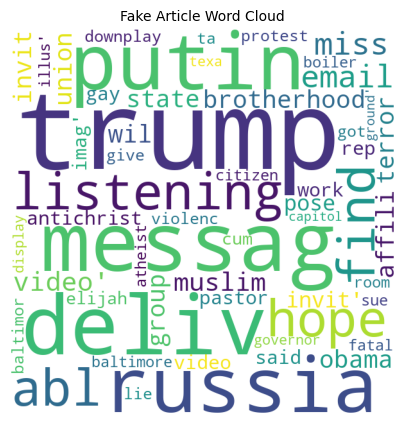

In [25]:
#plot wordcloud
fake_wordcloud = WordCloud(width=600, height=600, background_color='white').generate_from_text(str(fake_articles_words))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(fake_wordcloud)
plt.axis('off')
plt.title("Fake Article Word Cloud", fontsize=10)
plt.show()

In [26]:
#obtain a list of all real article titles
real_articles_words = X_train[y_train == 0].to_numpy()

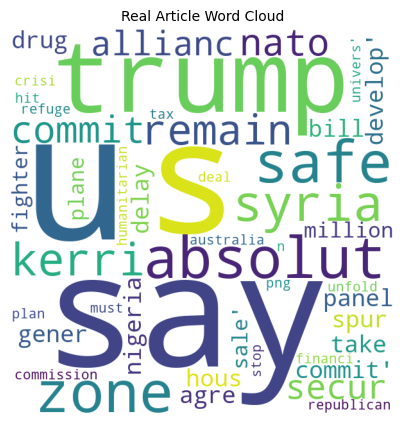

In [27]:
#plot wordcloud
fake_wordcloud = WordCloud(width=600, height=600, background_color='white').generate_from_text(str(real_articles_words))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(fake_wordcloud)
plt.axis('off')
plt.title("Real Article Word Cloud", fontsize=10)
plt.show()

### Next Steps and Recommendations

Further work can be done to add new features to the dataset rather than just the vectorized tokens. Given the performance of our model, it is clear that simply using the Tfidf Vectorizer (or even a Count Vectorizer) is enough to build an effective predictive model. However, adding other feature before the text is preprocessed such as the proportion of capital letters in the title (I would assume that fake news titles have more caps) and the existence and counts of different types of punctuation could lead to a model with better predictive power. 

In addition to adding more features, it would be extremely interesting the see a Neural Network trained on this data. Obviously, much more work would need to go into designing the layers of such the Neural Network and it would require more computing time than any of the models trained in this analysis, but it would also probably outperform the models tested here. One possible negative of a Neural Network is that it is much more of a black-box model than the models tested here and the prediction process would lose some interpretability.

Lastly, the articles in this dataset on go up until 2018. In order for a fake news prediction model to be used by social media and news companies in real time, more recent date will need to be collected and trained on. However, this project serves to show that such a model is possible and extremely effective in such a classification task. 